In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1003. Ozone Sterols Healthy Asthma/P1003.3. Analyses/P1003.3.4. ML Visualizations/P1003.3.4.2. Decision Boundary Plot/Output')
cur_date = "091022"

library(readxl)
library(tidyverse)
library(randomForest)
library(gganimate)
library(mvnfast)
library(MetBrewer)
library(e1071)

#reading in files
ozone_data = data.frame(read_excel("Input/Imputed_Ozone_Data_042622.xlsx")) 
demographics_data = data.frame(read_excel("Input/SubjectInfo_011822.xlsx", sheet = 2))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

randomForest 4.7-1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


No renderer backend detected. gganimate will default to writing frames to separate files
Consider installing:
- the `gifski` package for gif output
- the `av` package for video output
and restarting the R session



In [2]:
head(ozone_data)
head(demographics_data)

,Original_Subject_No,Subject_No,Subject_ID,Disease_Status,Sample_Type,Time_Point,Inflammatory_Responder,Lung_Responder,Category,Variable,Value
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Sample_Weight,817.00
2,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,TCC,395000.00
3,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,TCC_Weight,483.48
4,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Neutrophils_Percent,25.00
5,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Neutrophils,98750.00
6,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Neutrophils_Weight,121.00


,Original_Subject_No,Subject_No,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Visit_Season
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,4,1,AS_1,M,W,NH,30,23.3,AS,Fa
2,7,2,AS_2,F,W,NH,39,32.7,AS,Sp
3,11,3,AS_3,M,W,NH,23,23.0,AS,Fa
4,13,4,AS_4,M,W,NH,20,21.4,AS,Wi
5,15,5,AS_5,F,B,NH,20,34.5,AS,Su
6,16,6,AS_6,F,W,NH,25,25.2,AS,Su


In supervised machine learning, Decision Boundaries help assess how well two predictors (on the x and y axis) separate different classes in classification. A clear decision boundary has most classes well separated. 

In [3]:
#getting baseline plasma data (not using covariates)
plasma_baseline_ozone_data = full_join(demographics_data, ozone_data) %>%
    #only interested in plasma soluble mediators (cytokines/sterols) at baseline
    filter(Sample_Type == "P" & Time_Point == "Pre") %>%
    filter(Category == "Sterol") %>%
    select(-c("Sample_Type", "Time_Point", "Category", "Original_Subject_No", "Subject_No", "Subject_ID")) %>%
    distinct()
head(plasma_baseline_ozone_data)

Joining, by = c("Original_Subject_No", "Subject_No", "Subject_ID",
"Disease_Status")


,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Visit_Season,Inflammatory_Responder,Lung_Responder,Variable,Value
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,M,W,NH,30,23.3,AS,Fa,NR,NR,25OH_VitD,130.325
2,M,W,NH,30,23.3,AS,Fa,NR,NR,25OH_VitD,47.181
3,M,W,NH,30,23.3,AS,Fa,NR,NR,SecoB,1.816
4,M,W,NH,30,23.3,AS,Fa,NR,NR,25OH_VitD,16.537
5,M,W,NH,30,23.3,AS,Fa,NR,NR,25OH_VitD,15.326
6,M,W,NH,30,23.3,AS,Fa,NR,NR,25OH_VitD,280.856


In [4]:
#first pivoting wider bc thats what random forest prefers
wider_data = pivot_wider(plasma_baseline_ozone_data,
                         #not actually taking the mean of multiple values
                         #did this bc cols would be type list rather than double
                         names_from = Variable, values_from = Value, values_fn = mean)

head(wider_data)

Sex,Race,Ethnicity,Age,BMI,Disease_Status,Visit_Season,Inflammatory_Responder,Lung_Responder,25OH_VitD,SecoB,bEP_Chol,Lan,Zym,DHL,Des,dHLan,Zyme,Lath,Chol
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M,W,NH,30,23.3,AS,Fa,NR,NR,61.57312,1.816,25.669,0.171,0.057,0.224,0.641,0.004,3.014,1.969,1110.442
F,W,NH,39,32.7,AS,Sp,R,NR,20.31488,112.521,17.867,0.062,0.046,0.106,0.286,0.015,2.508,1.287,673.328
M,W,NH,23,23.0,AS,Fa,NR,R,50.92712,6.686,8.066,0.052,0.046,0.094,0.279,0.005,1.549,1.200,537.509
M,W,NH,20,21.4,AS,Wi,R,NR,30.55712,48.416,10.132,0.013,0.046,0.085,0.297,0.016,1.833,1.062,482.396
F,B,NH,20,34.5,AS,Su,R,NR,29.90213,13.006,13.090,0.117,0.060,0.116,0.255,0.020,3.628,1.795,586.750
F,W,NH,25,25.2,AS,Su,NR,NR,33.79675,36.458,14.331,0.022,0.034,0.077,0.272,0.006,1.914,0.966,639.636


In [5]:
#making responder columns binary denoted by 0 = non-responder and 1 = responder 
wider_data = wider_data %>%
    # var selection
    #select(-DHL) %>% 
    mutate(Lung_Responder = relevel(factor(ifelse(Lung_Responder == "R", 1, 0)), ref = "0"),
           Inflammatory_Responder = relevel(factor(ifelse(Inflammatory_Responder == "R", 1, 0)), ref = "0")) %>%
    #for some reason RF didn't this variable so I changed it
    rename(X25OH_VitD = `25OH_VitD`) 

lung_resp_df = wider_data[,c(1:7, 9:20)]

head(lung_resp_df)

Sex,Race,Ethnicity,Age,BMI,Disease_Status,Visit_Season,Lung_Responder,X25OH_VitD,SecoB,bEP_Chol,Lan,Zym,DHL,Des,dHLan,Zyme,Lath,Chol
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M,W,NH,30,23.3,AS,Fa,0,61.57312,1.816,25.669,0.171,0.057,0.224,0.641,0.004,3.014,1.969,1110.442
F,W,NH,39,32.7,AS,Sp,0,20.31488,112.521,17.867,0.062,0.046,0.106,0.286,0.015,2.508,1.287,673.328
M,W,NH,23,23.0,AS,Fa,1,50.92712,6.686,8.066,0.052,0.046,0.094,0.279,0.005,1.549,1.200,537.509
M,W,NH,20,21.4,AS,Wi,0,30.55712,48.416,10.132,0.013,0.046,0.085,0.297,0.016,1.833,1.062,482.396
F,B,NH,20,34.5,AS,Su,0,29.90213,13.006,13.090,0.117,0.060,0.116,0.255,0.020,3.628,1.795,586.750
F,W,NH,25,25.2,AS,Su,0,33.79675,36.458,14.331,0.022,0.034,0.077,0.272,0.006,1.914,0.966,639.636


# Decision Boundary Calculation

In [6]:
smaller_lung_data = data.frame(lung_resp_df[,c("X25OH_VitD", "Chol", "Lung_Responder")])
model_lung = svm(Lung_Responder~., data = smaller_lung_data, kernel = "radial")

In [7]:
#obtaining grid values and predictions visualize using ggplot
get_grid_df <- function(model, data, class = NULL, predict_type = "class",
  resolution = 100, showgrid = TRUE, ...) {

  #plotting original data
  if(!is.null(class)) cl <- data[,class] else cl <- 1
  data <- data[,1:2]
  k <- length(unique(cl))

  # make grid (between min and max for each variable)
  r <- sapply(data, range, na.rm = TRUE)
  xs <- seq(r[1,1], r[2,1], length.out = resolution)
  ys <- seq(r[1,2], r[2,2], length.out = resolution)
  g <- cbind(rep(xs, each=resolution), rep(ys, time = resolution))
  colnames(g) <- colnames(r)
  g <- as.data.frame(g)
    
  ### guess how to get class labels from predict
  ### (unfortunately not very consistent between models)
  p <- predict(model, g, type = predict_type)
  g$Pred_Class = p
    
  return(g)
}

# calling function
grid_df_lung = get_grid_df(model_lung, smaller_lung_data, class = "Lung_Responder")
head(grid_df_lung)

,X25OH_VitD,Chol,Pred_Class
,<dbl>,<dbl>,<fct>
1,20.31488,332.5350,0
2,20.31488,340.3926,0
3,20.31488,348.2503,0
4,20.31488,356.1079,0
5,20.31488,363.9656,0
6,20.31488,371.8232,0


# Decision Boundary Plot

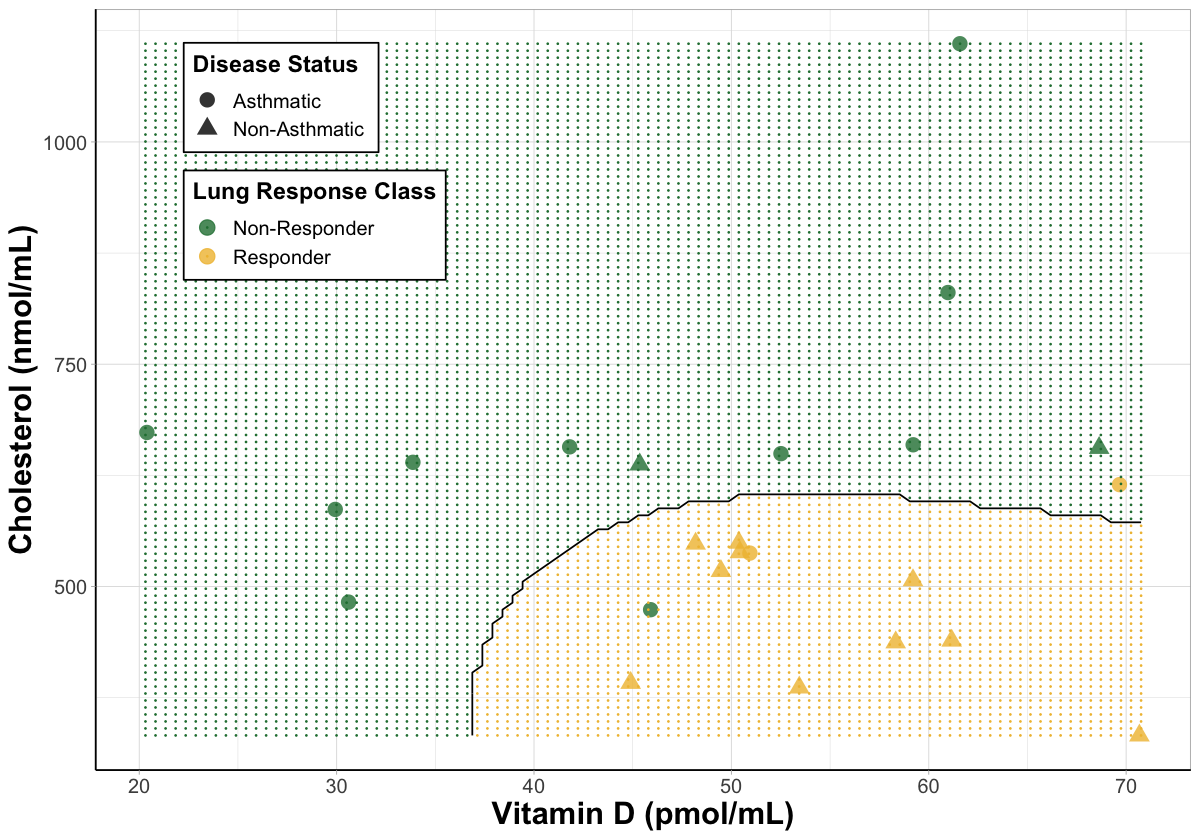

In [8]:
options(repr.plot.width=10, repr.plot.height=7) #changing size

#choosing palette from package
metbrewer_colors = MetPalettes$Lakota[[1]]

FigureX = ggplot() +
  geom_point(data = lung_resp_df, aes(x = X25OH_VitD, y = Chol, color = Lung_Responder, shape = Disease_Status),
            position = position_jitter(w = 0.1, h = 0.1), size = 4, alpha = 0.8) + 
  geom_contour(data = grid_df_lung, aes(x = X25OH_VitD, y = Chol, z = as.numeric(Pred_Class == "1")), color = "black", 
               breaks = 0.5) + #adds contour line
  geom_point(data = grid_df_lung, aes(x = X25OH_VitD, y = Chol, color = Pred_Class), size = 0.1) + #shades plot

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = c(0.2,0.8), # move legend to top left corner
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Vitamin D (pmol/mL)', y = 'Cholesterol (nmol/mL)') + #changing axis labels 

  scale_color_manual(name = "Lung Response Class",
                      values = c(metbrewer_colors[5], metbrewer_colors[2]),
                      labels = c('Non-Responder','Responder')) + #reordering
  scale_shape_manual(name = "Disease Status",
                     values = c(16,17),
                     labels = c('Asthmatic','Non-Asthmatic'))

FigureX

In [9]:
#exporting figure
ggsave(FigureX, 
       filename = 'FigureX.pdf',
       path = Output,
       width = 10, height = 7)